In [1]:
import gymnasium as gym
from gymnasium import spaces

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

ticker = "MSFT"
df = yf.download(ticker, period='60d', interval="2m")

df.columns = [i[0] for i in df.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:


# Function to compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute MACD
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Compute Indicators
df["SMA_10"] = df["High"].rolling(window=10).mean()
df["EMA_10"] = df["High"].ewm(span=10, adjust=False).mean()
df["RSI_14"] = compute_rsi(df["High"], window=14)
df["MACD"], df["Signal_Line"] = compute_macd(df["High"])
df["BB_Mid"] = df["High"].rolling(window=20).mean()
df["BB_Std"] = df["High"].rolling(window=20).std()
df["BB_Upper"] = df["BB_Mid"] + (df["BB_Std"] * 2)
df["BB_Lower"] = df["BB_Mid"] - (df["BB_Std"] * 2)

price_volume = (df["High"] * df["Volume"]).rolling(window=20).sum().shift(1)
volume_sum = df["Volume"].rolling(window=20).sum().shift(1)
df["VWAP"] = price_volume / volume_sum


fib_window = 26  # adjust to match your feature engineering style

rolling_high = df["High"].rolling(window=fib_window).max().shift(1)
rolling_low = df["Low"].rolling(window=fib_window).min().shift(1)

df["Fib_23.6"] = rolling_low + 0.236 * (rolling_high - rolling_low)
df["Fib_38.2"] = rolling_low + 0.382 * (rolling_high - rolling_low)
df["Fib_61.8"] = rolling_low + 0.618 * (rolling_high - rolling_low)

df.drop(columns=["BB_Std"], inplace=True)

# Shift indicators to prevent data leakage

for col in ["SMA_10", "EMA_10", "RSI_14", "MACD", "Signal_Line", "VWAP", "BB_Mid", "BB_Upper", "BB_Lower"]:
    df[col] = df[col].shift(1)

# Drop NaN values resulting from rolling calculations
df.dropna(inplace=True)


In [5]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-03-03 15:22:00+00:00,394.140015,394.535187,393.691193,393.820007,106536,393.762250,393.936588,39.770921,-0.947974,-1.037332,394.425993,396.327067,392.524919,394.680206,393.720293,394.694846,396.270150
2025-03-03 15:24:00+00:00,394.054993,394.479889,393.859985,394.220001,79951,393.867767,394.045424,50.510883,-0.839062,-0.997678,394.354878,396.115990,392.593767,394.542172,393.526772,394.381603,395.763386
2025-03-03 15:26:00+00:00,394.425995,394.750000,393.859985,394.054993,86296,393.931757,394.124418,54.943700,-0.748581,-0.947859,394.290373,395.923069,392.657677,394.467633,393.392250,394.163860,395.411121
2025-03-03 15:28:00+00:00,394.625000,394.682007,394.149994,394.429993,63936,394.030756,394.238160,53.436186,-0.647614,-0.887810,394.222878,395.637669,392.808086,394.398890,393.176315,393.814339,394.845665
2025-03-03 15:30:00+00:00,394.350006,395.000000,394.279999,394.614990,97494,394.175806,394.318859,57.839074,-0.566552,-0.823558,394.154478,395.304917,393.004040,394.291776,393.138857,393.753707,394.747575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14 19:32:00+00:00,389.184998,389.271210,388.779999,389.174988,52104,389.934607,389.748756,63.625534,0.340855,0.387942,389.451048,390.754700,388.147396,389.489369,388.591444,388.920220,389.451667
2025-04-14 19:34:00+00:00,389.149994,389.279999,388.950012,389.160004,46172,389.839728,389.661929,51.485016,0.280503,0.366454,389.491609,390.713335,388.269884,389.537523,388.591444,388.920220,389.451667
2025-04-14 19:36:00+00:00,389.119995,389.479095,389.010010,389.260010,37819,389.736539,389.592487,45.366448,0.230723,0.339308,389.535109,390.652152,388.418066,389.561877,388.591444,388.920220,389.451667


In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import DQN


## Step is to go all in while buying and while selling

In [12]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_cash=1000, initial_stock=10, context_width=10, offset=3):
        super(TradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.initial_stock = initial_stock  # NEW

        self.context_width = context_width
        self.offset = offset
        self.num_features = df.shape[1]

        self.action_space = spaces.Discrete(3)

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.context_width, self.num_features + 2),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.context_width
        self.cash = self.initial_cash
        self.stock_held = self.initial_stock  # NEW

        if seed is not None:
            np.random.seed(seed)

        obs = self._get_obs()
        info = {}
        return obs, info


    def render(self, mode="human"):
        if self.current_step >= len(self.df):
            print("End of data reached. No further rendering possible.")
            return

        price = self.df.iloc[self.current_step]["Close"]
        net_worth = self.cash + self.stock_held * price
        profit_loss = net_worth - (self.initial_cash + self.initial_stock * price)
        status = "PROFIT" if profit_loss > 0 else "LOSS" if profit_loss < 0 else "BREAKEVEN"

        print(f"Step: {self.current_step}, Cash: {self.cash:.2f}, Stock: {self.stock_held}, "
              f"Net Worth: {net_worth:.2f}, P/L: {profit_loss:.2f} ({status})")

    
    def _get_obs(self):
        window = self.df.iloc[self.current_step - self.context_width:self.current_step].values.astype(np.float32)
        cash_stock = np.array([[self.cash, self.stock_held]] * self.context_width, dtype=np.float32)
        obs = np.concatenate((window, cash_stock), axis=1)
        return obs  # 2D now: [context_width x (features + 2)]

    def step(self, action):
        terminated = False
        truncated = False
        info = {}
    
        current_price = self.df.iloc[self.current_step]["Close"]
        prev_net_worth = self.cash + self.stock_held * current_price
    
        # --- Execute All-In Actions ---
        if action == 1 and self.cash >= current_price:
            # All-In Buy
            units_to_buy = int(self.cash // current_price)
            self.cash -= units_to_buy * current_price
            self.stock_held += units_to_buy
    
        elif action == 2 and self.stock_held > 0:
            # All-Out Sell
            self.cash += self.stock_held * current_price
            self.stock_held = 0
    
        # else: HOLD — do nothing
    
        self.current_step += 1
    
        if self.current_step + self.offset >= len(self.df):
            terminated = True
            self.current_step = len(self.df) - 1
    
        # Recalculate net worth
        new_price = self.df.iloc[self.current_step]["Close"]
        new_net_worth = self.cash + self.stock_held * new_price
    
        # Net worth delta reward (normalized)
        reward = (new_net_worth - prev_net_worth) / (prev_net_worth + 1e-6)
    
        # Optional penalty for holding
        if action == 0:
            reward -= 0.001
    
        # Optional final bonus on episode end
        if terminated:
            reward += (new_net_worth - self.initial_cash) / self.initial_cash
    
        obs = self._get_obs()
        return obs, reward, terminated, truncated, info




In [14]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-03-03 15:22:00+00:00,394.140015,394.535187,393.691193,393.820007,106536,393.762250,393.936588,39.770921,-0.947974,-1.037332,394.425993,396.327067,392.524919,394.680206,393.720293,394.694846,396.270150
2025-03-03 15:24:00+00:00,394.054993,394.479889,393.859985,394.220001,79951,393.867767,394.045424,50.510883,-0.839062,-0.997678,394.354878,396.115990,392.593767,394.542172,393.526772,394.381603,395.763386
2025-03-03 15:26:00+00:00,394.425995,394.750000,393.859985,394.054993,86296,393.931757,394.124418,54.943700,-0.748581,-0.947859,394.290373,395.923069,392.657677,394.467633,393.392250,394.163860,395.411121
2025-03-03 15:28:00+00:00,394.625000,394.682007,394.149994,394.429993,63936,394.030756,394.238160,53.436186,-0.647614,-0.887810,394.222878,395.637669,392.808086,394.398890,393.176315,393.814339,394.845665
2025-03-03 15:30:00+00:00,394.350006,395.000000,394.279999,394.614990,97494,394.175806,394.318859,57.839074,-0.566552,-0.823558,394.154478,395.304917,393.004040,394.291776,393.138857,393.753707,394.747575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14 19:32:00+00:00,389.184998,389.271210,388.779999,389.174988,52104,389.934607,389.748756,63.625534,0.340855,0.387942,389.451048,390.754700,388.147396,389.489369,388.591444,388.920220,389.451667
2025-04-14 19:34:00+00:00,389.149994,389.279999,388.950012,389.160004,46172,389.839728,389.661929,51.485016,0.280503,0.366454,389.491609,390.713335,388.269884,389.537523,388.591444,388.920220,389.451667
2025-04-14 19:36:00+00:00,389.119995,389.479095,389.010010,389.260010,37819,389.736539,389.592487,45.366448,0.230723,0.339308,389.535109,390.652152,388.418066,389.561877,388.591444,388.920220,389.451667


In [16]:
# ---------------------------
# Training
# ---------------------------
context_width = 10
offset = 1

split_point = int(len(df) * 0.7)
train_df = df[:split_point]
test_df = df[split_point:]

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN

train_env = TradingEnv(train_df, context_width=context_width, offset=offset)
train_env = DummyVecEnv([lambda: train_env])

steps_per_episode = df.shape[0] - context_width
total_timesteps = 150 * steps_per_episode

model = DQN("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=total_timesteps)




Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.823    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 488      |
|    time_elapsed     | 34       |
|    total_timesteps  | 16756    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 214      |
|    n_updates        | 4163     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.646    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 470      |
|    time_elapsed     | 71       |
|    total_timesteps  | 33512    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 194      |
|    n_updates        | 8352     |
----------------------------------
----------------------------------
| rollout/            |          |
| 

Step: 11, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: 0.15 (PROFIT)
Step: 12, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -0.25 (LOSS)
Step: 13, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -0.55 (LOSS)
Step: 14, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -2.75 (LOSS)
Step: 15, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -6.15 (LOSS)
Step: 16, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -4.49 (LOSS)
Step: 17, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -6.15 (LOSS)
Step: 18, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -4.65 (LOSS)
Step: 19, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -9.80 (LOSS)
Step: 20, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -9.00 (LOSS)
Step: 21, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -9.00 (LOSS)
Step: 22, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -7.60 (LOSS)
Step: 23, Cash: 4786.35, Stock: 0, Net Worth: 4786.35, P/L: -5.65 (LOSS)
Step: 24, Cash: 4786.35, Stock: 0, Net Worth: 4786

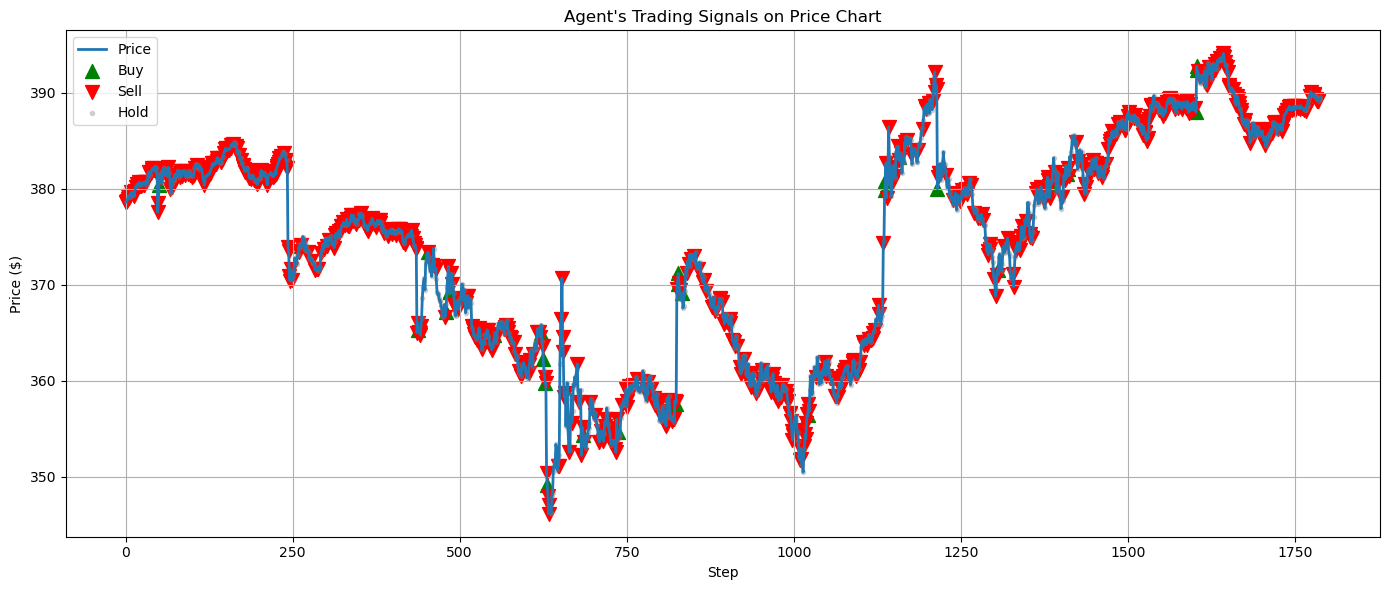

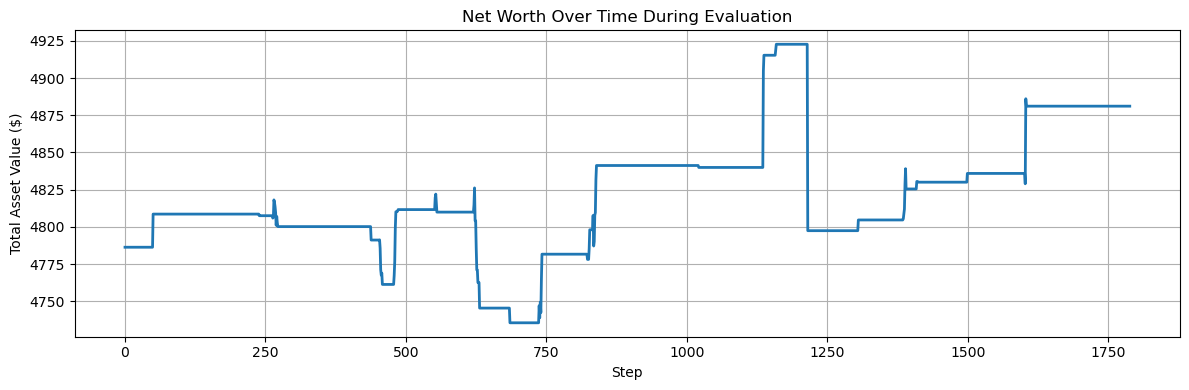

In [18]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df, context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Logging actions, prices, net worth...
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)

    # SEE RENDER OUTPUT
    test_env.render()  

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='.', color='gray', alpha=0.3, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

Step: 11, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: 1.20 (PROFIT)
Step: 12, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: 0.50 (PROFIT)
Step: 13, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -0.40 (LOSS)
Step: 14, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -7.60 (LOSS)
Step: 15, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -8.50 (LOSS)
Step: 16, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -11.10 (LOSS)
Step: 17, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -11.80 (LOSS)
Step: 18, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -11.00 (LOSS)
Step: 19, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -9.45 (LOSS)
Step: 20, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -11.35 (LOSS)
Step: 21, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -7.35 (LOSS)
Step: 22, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -7.80 (LOSS)
Step: 23, Cash: 4813.60, Stock: 0, Net Worth: 4813.60, P/L: -9.40 (LOSS)
Step: 24, Cash: 4813.60, Stock: 0, Net Worth:

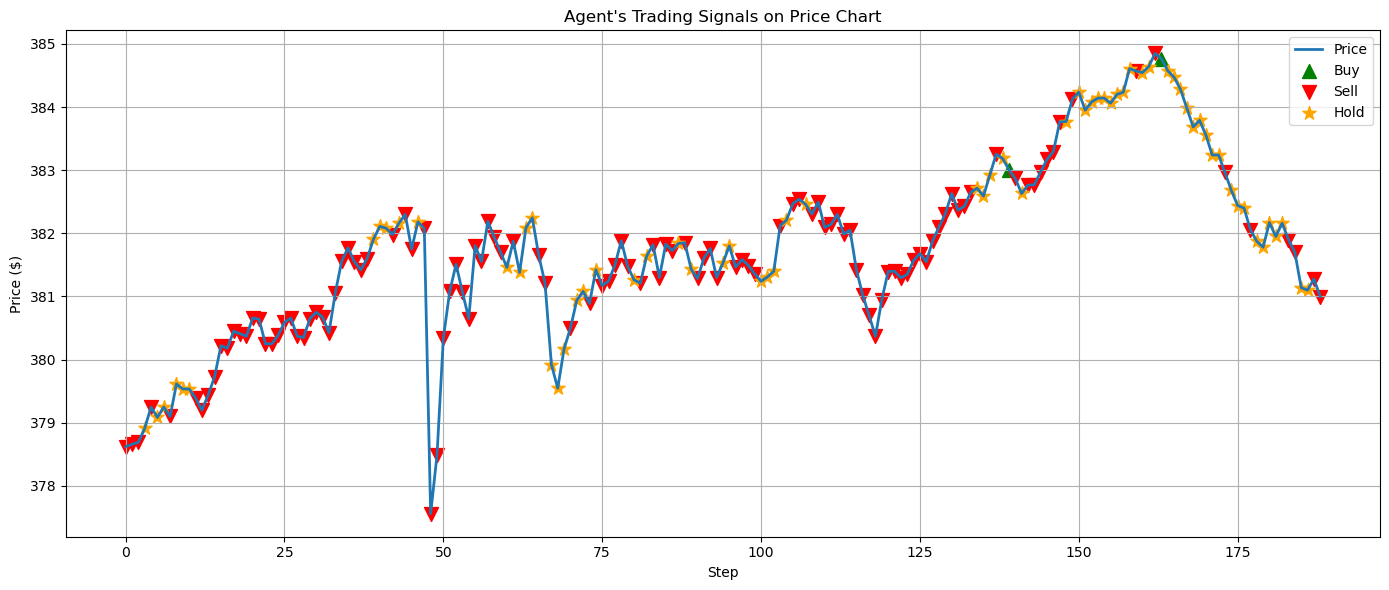

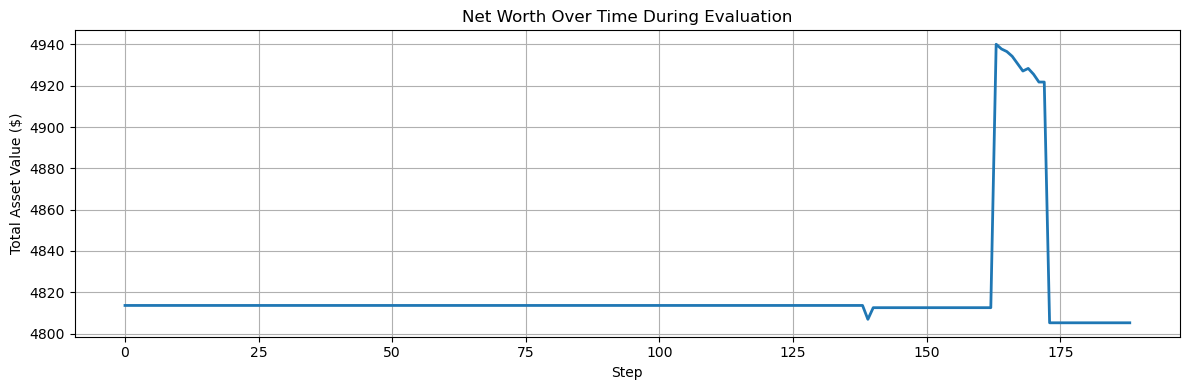

In [26]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df[100:300], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Tracking
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()  
    
# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='*', color='orange', s=100, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

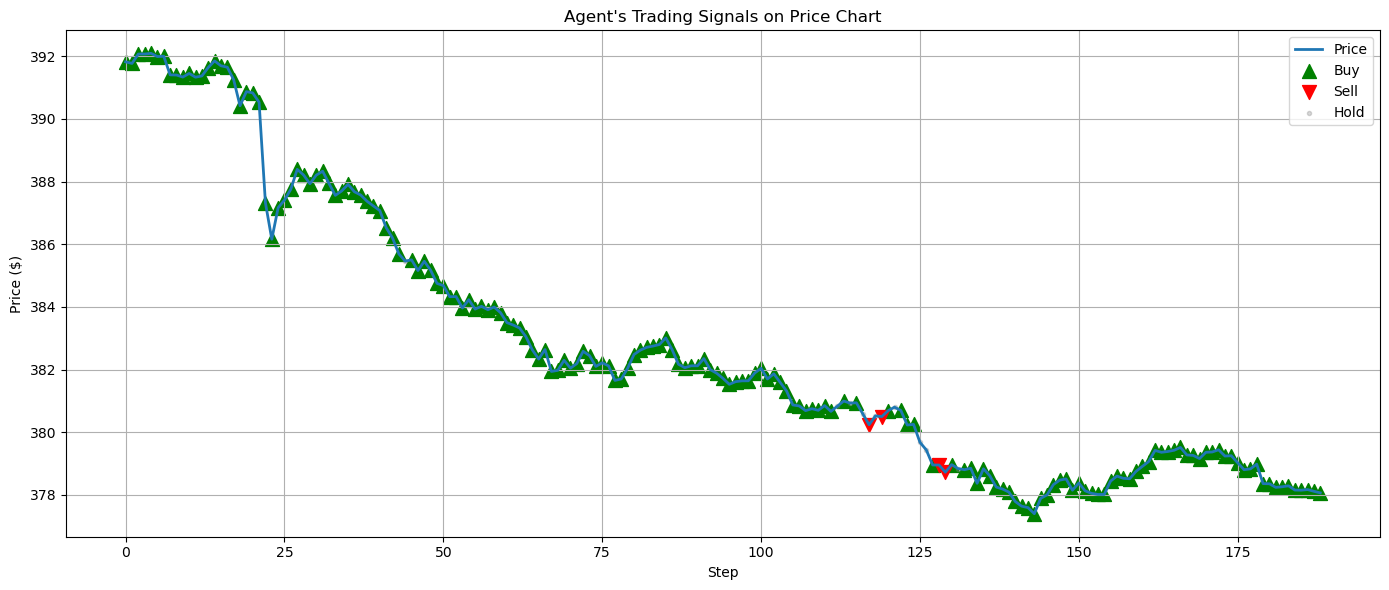

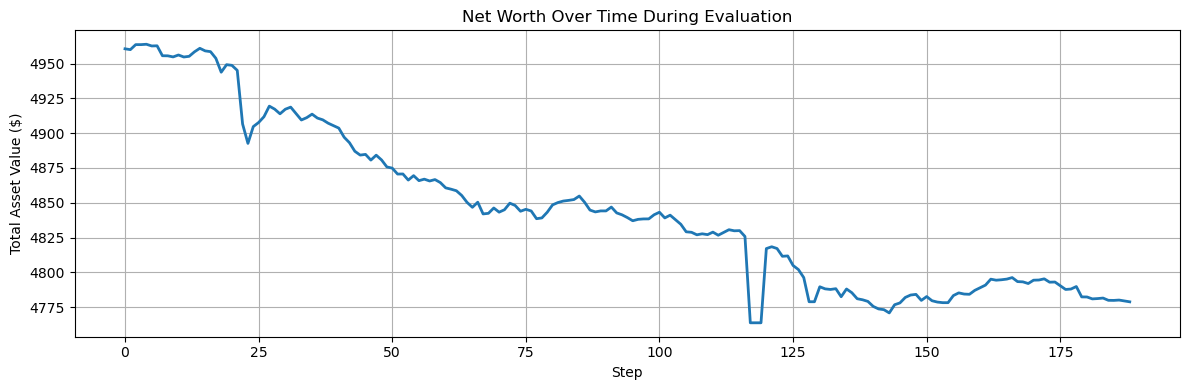

In [17]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df[300:500], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Tracking
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='.', color='gray', alpha=0.3, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

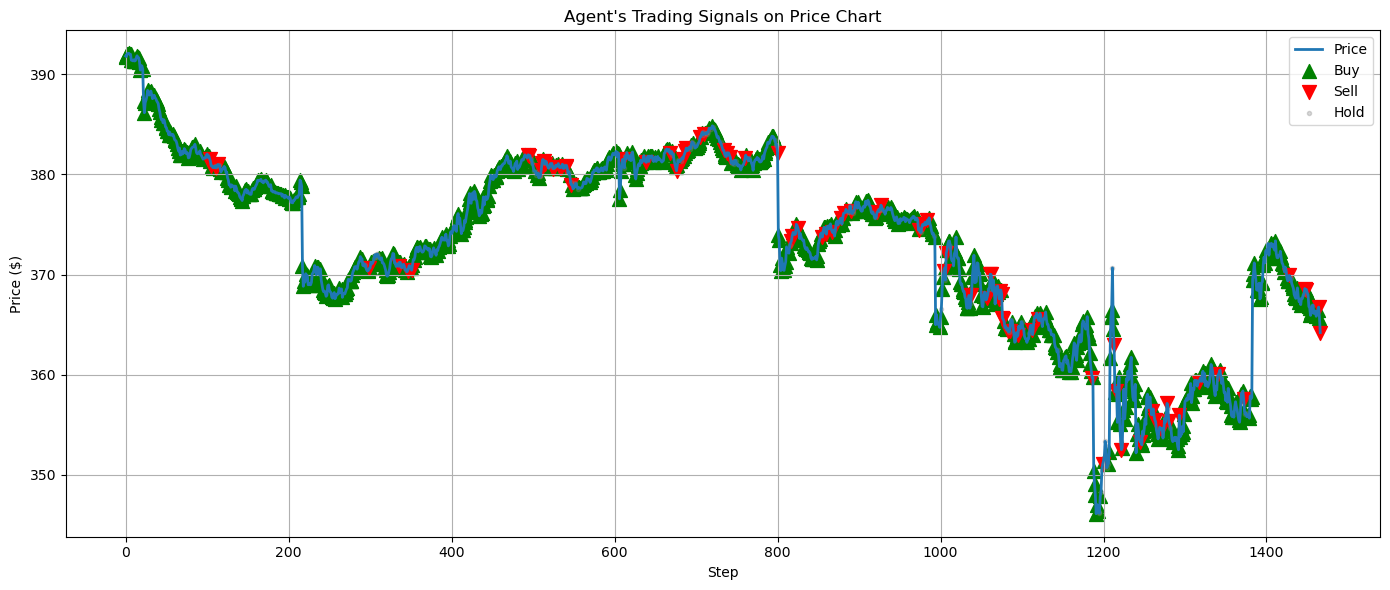

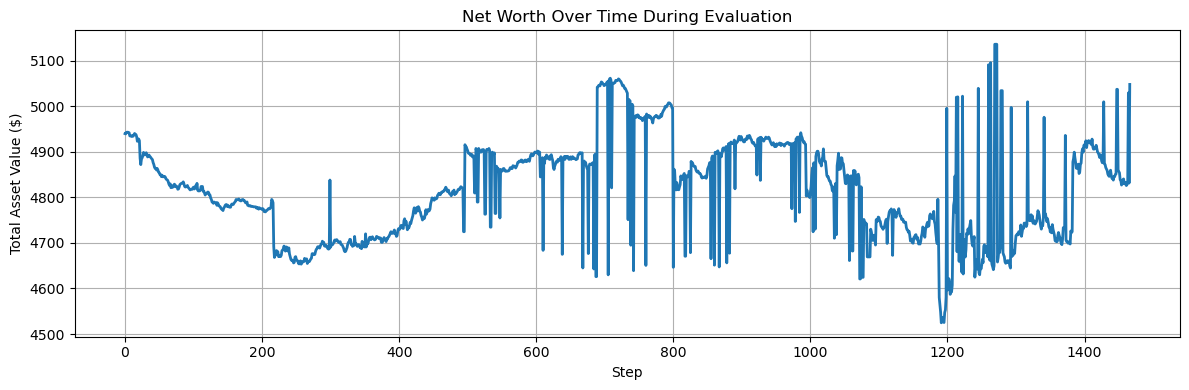

In [18]:
# ---------------------------
# Evaluation
# ---------------------------
import matplotlib.pyplot as plt

test_env = TradingEnv(test_df[500:], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

# Logs
actions = []
prices = []
net_worths = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    # Tracking
    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)

# ---------------------------
# Plot Trading Signals
# ---------------------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='.', color='gray', alpha=0.3, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Net Worth
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()